## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from random import sample

from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import binarize

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [18]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(10)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
27111,00007060_004.png,No Finding,4,7060,43,M,PA,2500,2048,0.168,0.168,NaN,/data/images_004/images/00007060_004.png
8372,00002219_005.png,No Finding,5,2219,37,F,PA,2048,2500,0.171,0.171,NaN,/data/images_002/images/00002219_005.png
92387,00023075_003.png,Pneumothorax,3,23075,29,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00023075_003.png
55992,00013993_048.png,Atelectasis|Consolidation|Effusion,48,13993,42,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00013993_048.png
71875,00017712_002.png,Consolidation|Effusion|Infiltration|Nodule,2,17712,57,M,PA,2982,2991,0.143,0.143,NaN,/data/images_008/images/00017712_002.png
97143,00025626_000.png,Infiltration,0,25626,36,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00025626_000.png
39171,00010270_008.png,Atelectasis,8,10270,16,M,PA,2846,2865,0.143,0.143,NaN,/data/images_005/images/00010270_008.png
57684,00014294_013.png,Consolidation|Infiltration,13,14294,37,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00014294_013.png
100009,00026495_002.png,Atelectasis,2,26495,73,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00026495_002.png
70326,00017325_003.png,Nodule|Pneumothorax,3,17325,66,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017325_003.png


In [23]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(20)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
24850,00006521_003.png,No Finding,3,6521,55,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
54168,00013625_005.png,No Finding,5,13625,63,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
90461,00022519_004.png,Infiltration,4,22519,66,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88842,00022031_000.png,Infiltration,0,22031,47,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
42906,00011053_004.png,No Finding,4,11053,69,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75135,00018434_001.png,Infiltration,1,18434,52,M,PA,2810,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
55893,00013985_001.png,No Finding,1,13985,56,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
83257,00020442_000.png,No Finding,0,20442,51,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75235,00018464_000.png,Infiltration,0,18464,57,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
92222,00023037_000.png,Infiltration,0,23037,35,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
all_xray_df['path'].head()

0    /data/images_001/images/00000001_000.png
1    /data/images_001/images/00000001_001.png
2    /data/images_001/images/00000001_002.png
3    /data/images_001/images/00000002_000.png
4    /data/images_001/images/00000003_000.png
Name: path, dtype: object

In [25]:
all_xray_df=all_xray_df[all_xray_df['View Position']=='PA']

In [26]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
len(all_xray_df['Image Index'].unique())

67310

In [28]:
len(all_xray_df)

67310

In [29]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

## Create your training and testing data:

In [ ]:
# def create_splits(vargs):
    
#     ## Either build your own or use a built-in library to split your original dataframe into two sets 
#     ## that can be used for training and testing your model
#     ## It's important to consider here how balanced or imbalanced you want each of those sets to be
#     ## for the presence of pneumonia
    
#     # Todo
    
#     return train_data, val_data

In [30]:

train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Pneumonia'])

In [31]:
train_df['Pneumonia'].sum()/len(train_df)

0.009359679096716684

In [32]:

valid_df['Pneumonia'].sum()/len(valid_df)

0.009359679096716684

In [33]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
54963,00013767_001.png,Fibrosis|Infiltration,1,13767,58,F,PA,2992,2991,0.143,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15989,00004248_000.png,No Finding,0,4248,25,F,PA,2682,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49403,00012532_000.png,No Finding,0,12532,42,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58031,00014358_019.png,No Finding,19,14358,43,F,PA,2490,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21783,00005778_004.png,No Finding,4,5778,61,M,PA,2970,2649,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [34]:
train_df.shape

(53848, 28)

In [35]:
train_df[(train_df['Infiltration']==0) & (train_df['Effusion']==0) & (train_df['Pneumonia']==0) & (train_df['Edema']==0) & (train_df['Atelectasis']==0) ]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
15989,00004248_000.png,No Finding,0,4248,25,F,PA,2682,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49403,00012532_000.png,No Finding,0,12532,42,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58031,00014358_019.png,No Finding,19,14358,43,F,PA,2490,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21783,00005778_004.png,No Finding,4,5778,61,M,PA,2970,2649,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
93619,00023518_002.png,No Finding,2,23518,56,M,PA,2698,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92545,00023097_006.png,Pleural_Thickening,6,23097,37,M,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30232,00007883_000.png,No Finding,0,7883,72,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15964,00004235_002.png,No Finding,2,4235,29,F,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71710,00017665_000.png,No Finding,0,17665,55,M,PA,2992,2821,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [36]:
train_df[train_df.Pneumonia==1].shape

(504, 28)

In [37]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
#considering co-occurences might harm the purity of negative class
np_inds = train_df[ (train_df['Pneumonia']==0) ].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [38]:

train_df['Pneumonia'].sum()/len(train_df)

0.5

Assuming 20% prevalence of pneumonia in real world setting

In [39]:
valid_df


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
68207,00016822_000.png,No Finding,0,16822,40,F,PA,2658,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
52302,00013206_008.png,Mass,8,13206,14,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99253,00026237_000.png,No Finding,0,26237,35,F,PA,2970,2737,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
42169,00010841_005.png,Effusion,5,10841,63,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44053,00011355_054.png,Atelectasis|Mass|Pneumothorax,54,11355,28,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86611,00021372_000.png,No Finding,0,21372,22,M,PA,3056,2488,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
72694,00017920_007.png,No Finding,7,17920,45,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
64581,00015942_000.png,No Finding,0,15942,30,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11758,00003064_043.png,Effusion,43,3064,36,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[ (valid_df['Pneumonia']==0) ].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [41]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.2

In [42]:
train_df.shape

(1008, 28)

In [43]:
valid_df.shape

(630, 28)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

# Image Data Augmentation

In [ ]:
# def my_image_augmentation(vargs):
    
#     ## recommendation here to implement a package like Keras' ImageDataGenerator
#     ## with some of the built-in augmentations 
    
#     ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
#     ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
#     ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
#     ## built into something like a Keras package
    
#     # Todo
    
#     return my_idg


# def make_train_gen(vargs):
    
#     ## Create the actual generators using the output of my_image_augmentation for your training data
#     ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
# #     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
# #                                          directory=None, 
# #                                          x_col = ,
# #                                          y_col = ,
# #                                          class_mode = 'binary',
# #                                          target_size = , 
# #                                          batch_size = 
# #                                          )
#      # Todo

#     return train_gen


# def make_val_gen(vargs):
    
# #     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
# #                                              directory=None, 
# #                                              x_col = ,
# #                                              y_col = ',
# #                                              class_mode = 'binary',
# #                                              target_size = , 
# #                                              batch_size = ) 
    
#     # Todo
#     return val_gen

In [44]:
imgs = train_df.path

In [45]:
imgs

70087     /data/images_008/images/00017255_001.png
67228     /data/images_008/images/00016599_001.png
5876      /data/images_002/images/00001582_017.png
48504     /data/images_006/images/00012297_004.png
77046     /data/images_009/images/00018921_062.png
                            ...                   
57839     /data/images_007/images/00014321_000.png
106217    /data/images_012/images/00028599_000.png
25026     /data/images_004/images/00006592_000.png
23542     /data/images_003/images/00006236_000.png
87602     /data/images_010/images/00021640_006.png
Name: path, Length: 1008, dtype: object

In [46]:
len(imgs)

1008

In [47]:
train_df['Pneumonia_class']=train_df['Pneumonia']

In [48]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
70087,00017255_001.png,Atelectasis|Pneumonia,1,17255,26,F,PA,2814,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
67228,00016599_001.png,Infiltration|Pneumonia,1,16599,48,F,PA,2446,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5876,00001582_017.png,Infiltration|Mass|Pneumonia,17,1582,32,F,PA,2992,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
48504,00012297_004.png,Pneumonia,4,12297,47,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
77046,00018921_062.png,Edema|Infiltration|Pneumonia,62,18921,42,F,PA,2482,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [49]:
train_df['Pneumonia_class']=train_df['Pneumonia_class'].replace(1,'YES').replace(0,'NO')

In [50]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
70087,00017255_001.png,Atelectasis|Pneumonia,1,17255,26,F,PA,2814,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
67228,00016599_001.png,Infiltration|Pneumonia,1,16599,48,F,PA,2446,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
5876,00001582_017.png,Infiltration|Mass|Pneumonia,17,1582,32,F,PA,2992,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,YES
48504,00012297_004.png,Pneumonia,4,12297,47,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
77046,00018921_062.png,Edema|Infiltration|Pneumonia,62,18921,42,F,PA,2482,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57839,00014321_000.png,No Finding,0,14321,10,M,PA,2522,2325,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NO
106217,00028599_000.png,No Finding,0,28599,31,M,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NO
25026,00006592_000.png,Effusion,0,6592,37,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NO
23542,00006236_000.png,No Finding,0,6236,32,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NO


In [51]:
IMG_SIZE = (224, 224)

In [52]:
idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)



In [53]:
train_gen = idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 20)
                                         
                                         

Found 1008 validated image filenames belonging to 2 classes.


In [54]:
valid_df['Pneumonia_class']=valid_df['Pneumonia']

In [55]:
valid_df['Pneumonia_class']=valid_df['Pneumonia_class'].replace(1,'YES').replace(0,'NO')

In [56]:
val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32)

Found 630 validated image filenames belonging to 2 classes.


In [57]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

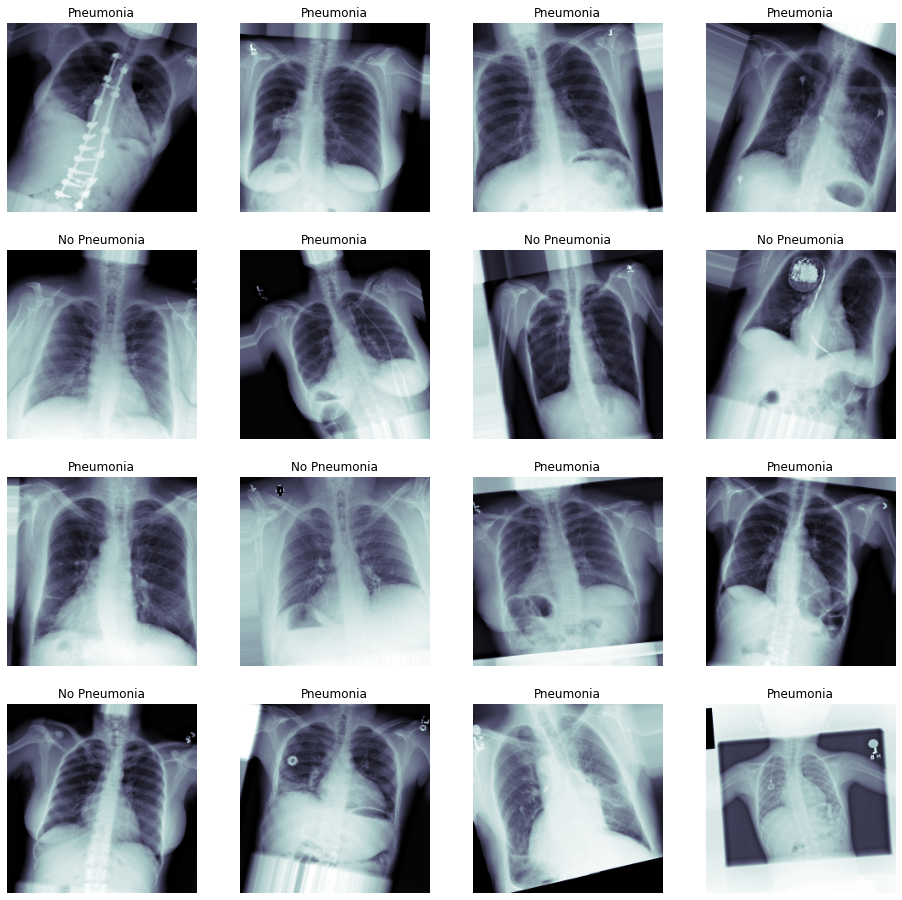

In [58]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

# VGG16

In [ ]:
# def load_pretrained_model(vargs):
    
#     # model = VGG16(include_top=True, weights='imagenet')
#     # transfer_layer = model.get_layer(lay_of_interest)
#     # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
#     # Todo
    
#     return vgg_model


In [59]:

model = VGG16(include_top=True, weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [60]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [61]:
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [62]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [ ]:
# def build_my_model(vargs):
    
#     # my_model = Sequential()
#     # ....add your pre-trained model, and then whatever additional layers you think you might
#     # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
#     # if you want to compile your model within this function, consider which layers of your pre-trained model, 
#     # you want to freeze before you compile 
    
#     # also make sure you set your optimizer, loss function, and metrics to monitor
    
#     # Todo
    
#     return my_model



# ## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
# ## to output class activation maps to aid in clinical interpretation of your model's results

# ARCHITECTURE 1

In [63]:

new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [64]:
optimizer = Adam(lr=1e-4, decay= 0.1)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [65]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [66]:
new_model.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 10)

Epoch 1/10
51/51 [==============================] - 32s 626ms/step - loss: 0.7209 - binary_accuracy: 0.5179 - val_loss: 0.6756 - val_binary_accuracy: 0.5312
Epoch 2/10
51/51 [==============================] - 26s 518ms/step - loss: 0.7058 - binary_accuracy: 0.5198 - val_loss: 0.7163 - val_binary_accuracy: 0.5312
Epoch 3/10
51/51 [==============================] - 24s 468ms/step - loss: 0.7034 - binary_accuracy: 0.5179 - val_loss: 0.7554 - val_binary_accuracy: 0.3438
Epoch 4/10
51/51 [==============================] - 25s 491ms/step - loss: 0.7011 - binary_accuracy: 0.5238 - val_loss: 0.7475 - val_binary_accuracy: 0.3750
Epoch 5/10
51/51 [==============================] - 25s 491ms/step - loss: 0.7002 - binary_accuracy: 0.5407 - val_loss: 0.7230 - val_binary_accuracy: 0.4688
Epoch 6/10
51/51 [==============================] - 26s 501ms/step - loss: 0.6896 - binary_accuracy: 0.5526 - val_loss: 0.7381 - val_binary_accuracy: 0.4062
Epoch 7/10
51/51 [==============================] - 26s 50

# ARCHITECTURE 2

In [100]:
new_model2 = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model2.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model2.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model2.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model2.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model2.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model2.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model2.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model2.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model2.add(Dense(1, activation='sigmoid'))

In [101]:
optimizer = Adam(lr=1e-4, decay=0.1)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [102]:
new_model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [103]:
new_model2.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 10)

Epoch 1/10
51/51 [==============================] - 26s 512ms/step - loss: 0.7842 - binary_accuracy: 0.5069 - val_loss: 0.6495 - val_binary_accuracy: 0.7500
Epoch 2/10
51/51 [==============================] - 25s 494ms/step - loss: 0.7662 - binary_accuracy: 0.5089 - val_loss: 0.6670 - val_binary_accuracy: 0.6875
Epoch 3/10
51/51 [==============================] - 25s 492ms/step - loss: 0.7414 - binary_accuracy: 0.5119 - val_loss: 0.6708 - val_binary_accuracy: 0.6875
Epoch 4/10
51/51 [==============================] - 25s 494ms/step - loss: 0.7583 - binary_accuracy: 0.4921 - val_loss: 0.6917 - val_binary_accuracy: 0.5938
Epoch 5/10
51/51 [==============================] - 25s 496ms/step - loss: 0.7416 - binary_accuracy: 0.4901 - val_loss: 0.6942 - val_binary_accuracy: 0.5625
Epoch 6/10
51/51 [==============================] - 25s 496ms/step - loss: 0.7367 - binary_accuracy: 0.5089 - val_loss: 0.6793 - val_binary_accuracy: 0.5938
Epoch 7/10
51/51 [==============================] - 25s 48

# ARCHITECTURE 3

In [90]:
new_model3=Sequential()
new_model3.add(Conv2D(32,kernel_size=(3,3),activation='relu', input_shape=(224,224,3)))

new_model3.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
new_model3.add(MaxPooling2D(pool_size=(2,2)))
new_model3.add(Dropout(0.25))

new_model3.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
new_model3.add(MaxPooling2D(pool_size=(2,2)))
new_model3.add(Dropout(0.25))

new_model3.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
new_model3.add(MaxPooling2D(pool_size=(2,2)))
new_model3.add(Dropout(0.25))

new_model3.add(Flatten())
new_model3.add(Dense(64, activation='relu'))
new_model3.add(Dropout(0.5))


new_model3.add(Dense(1, activation='sigmoid'))


In [91]:
new_model3.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [92]:
new_model3.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 10)

Epoch 1/10
51/51 [==============================] - 25s 484ms/step - loss: 0.6989 - binary_accuracy: 0.4940 - val_loss: 0.6814 - val_binary_accuracy: 0.7812
Epoch 2/10
51/51 [==============================] - 24s 472ms/step - loss: 0.6954 - binary_accuracy: 0.4990 - val_loss: 0.6918 - val_binary_accuracy: 0.6875
Epoch 3/10
51/51 [==============================] - 24s 474ms/step - loss: 0.6955 - binary_accuracy: 0.4931 - val_loss: 0.6905 - val_binary_accuracy: 0.7188
Epoch 4/10
51/51 [==============================] - 24s 465ms/step - loss: 0.6923 - binary_accuracy: 0.5188 - val_loss: 0.6920 - val_binary_accuracy: 0.6250
Epoch 5/10
51/51 [==============================] - 24s 468ms/step - loss: 0.6924 - binary_accuracy: 0.5179 - val_loss: 0.6911 - val_binary_accuracy: 0.6562
Epoch 6/10
51/51 [==============================] - 24s 473ms/step - loss: 0.6917 - binary_accuracy: 0.5089 - val_loss: 0.6917 - val_binary_accuracy: 0.6562
Epoch 7/10
51/51 [==============================] - 24s 47

# Taking Architecture 1

In [113]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_new_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [114]:
weight_path

'xray_class_new_model.best.hdf5'

### Start training! 

In [115]:
## train your model

# Todo

history = new_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =10 , 
                          callbacks = callbacks_list)

Epoch 1/10
51/51 [==============================] - 26s 503ms/step - loss: 0.6818 - binary_accuracy: 0.5635 - val_loss: 0.6944 - val_binary_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 0.69443, saving model to xray_class_new_model.best.hdf5
Epoch 2/10
51/51 [==============================] - 25s 487ms/step - loss: 0.6815 - binary_accuracy: 0.5794 - val_loss: 0.7001 - val_binary_accuracy: 0.5625

Epoch 00002: val_loss did not improve from 0.69443
Epoch 3/10
51/51 [==============================] - 25s 497ms/step - loss: 0.6897 - binary_accuracy: 0.5437 - val_loss: 0.7012 - val_binary_accuracy: 0.5625

Epoch 00003: val_loss did not improve from 0.69443
Epoch 4/10
51/51 [==============================] - 25s 483ms/step - loss: 0.6765 - binary_accuracy: 0.5704 - val_loss: 0.7008 - val_binary_accuracy: 0.5625

Epoch 00004: val_loss did not improve from 0.69443
Epoch 5/10
51/51 [==============================] - 25s 491ms/step - loss: 0.6852 - binary_accuracy: 0.5575 - val_lo

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [116]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 11ms/step


In [ ]:
# def plot_auc(t_y, p_y):
    
#     ## Hint: can use scikit-learn's built in functions here like roc_curve
    
#     # Todo
    
#     return

# ## what other performance statistics do you want to include here besides AUC? 


# # def ... 
# # Todo

# # def ...
# # Todo
    
# #Also consider plotting the history of your model training:

# def plot_history(history):
    
#     # Todo
#     return

In [71]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

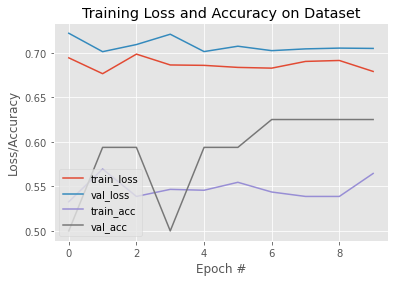

In [72]:

plot_history(history)

#  Taking Architecture 2

In [104]:
weight_path2="{}_new_model2.best.hdf5".format('xray_class')

checkpoint2 = ModelCheckpoint(weight_path2, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early2 = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list2 = [checkpoint2, early2]

In [105]:
weight_path2

'xray_class_new_model2.best.hdf5'

In [106]:
history2 = new_model2.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =10 , 
                          callbacks = callbacks_list2)

Epoch 1/10
51/51 [==============================] - 25s 493ms/step - loss: 0.7374 - binary_accuracy: 0.5020 - val_loss: 0.6743 - val_binary_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.67432, saving model to xray_class_new_model2.best.hdf5
Epoch 2/10
51/51 [==============================] - 25s 481ms/step - loss: 0.7295 - binary_accuracy: 0.5198 - val_loss: 0.6738 - val_binary_accuracy: 0.6562

Epoch 00002: val_loss improved from 0.67432 to 0.67385, saving model to xray_class_new_model2.best.hdf5
Epoch 3/10
51/51 [==============================] - 25s 496ms/step - loss: 0.7115 - binary_accuracy: 0.5536 - val_loss: 0.6784 - val_binary_accuracy: 0.6875

Epoch 00003: val_loss did not improve from 0.67385
Epoch 4/10
51/51 [==============================] - 25s 494ms/step - loss: 0.7357 - binary_accuracy: 0.5109 - val_loss: 0.6834 - val_binary_accuracy: 0.6250

Epoch 00004: val_loss did not improve from 0.67385
Epoch 5/10
51/51 [==============================] - 25s 482ms/

In [107]:
new_model2.load_weights(weight_path2)
pred_Y2 = new_model2.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 13ms/step


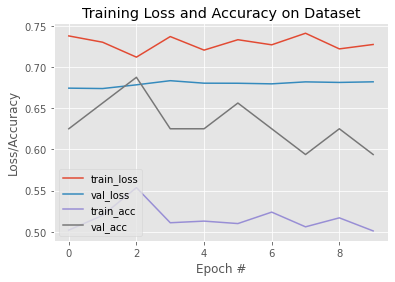

In [108]:
plot_history(history2)

# Taking Architecture 3

In [120]:
weight_path3="{}_new_model3.best.hdf5".format('xray_class')

checkpoint3 = ModelCheckpoint(weight_path3, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early3 = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list3 = [checkpoint3, early3]

In [121]:
history3 = new_model3.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =10 , 
                          callbacks = callbacks_list3)

Epoch 1/10
51/51 [==============================] - 25s 481ms/step - loss: 0.6900 - binary_accuracy: 0.5446 - val_loss: 0.6871 - val_binary_accuracy: 0.7188

Epoch 00001: val_loss improved from inf to 0.68714, saving model to xray_class_new_model3.best.hdf5
Epoch 2/10
51/51 [==============================] - 24s 468ms/step - loss: 0.6903 - binary_accuracy: 0.5208 - val_loss: 0.6876 - val_binary_accuracy: 0.6875

Epoch 00002: val_loss did not improve from 0.68714
Epoch 3/10
51/51 [==============================] - 24s 474ms/step - loss: 0.6931 - binary_accuracy: 0.5030 - val_loss: 0.6879 - val_binary_accuracy: 0.6875

Epoch 00003: val_loss did not improve from 0.68714
Epoch 4/10
51/51 [==============================] - 24s 471ms/step - loss: 0.6904 - binary_accuracy: 0.5308 - val_loss: 0.6888 - val_binary_accuracy: 0.6875

Epoch 00004: val_loss did not improve from 0.68714
Epoch 5/10
51/51 [==============================] - 24s 470ms/step - loss: 0.6903 - binary_accuracy: 0.5248 - val_l

In [122]:
new_model3.load_weights(weight_path3)
pred_Y3 = new_model3.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 3ms/step


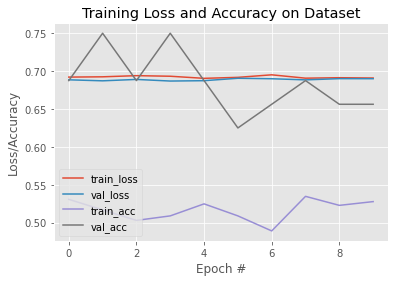

In [96]:
plot_history(history3)

# AUC PLOTS

In [73]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

### Architecture 1 ROC

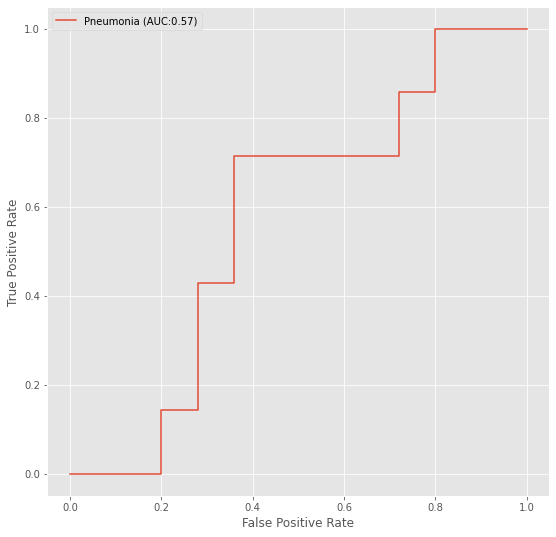

In [74]:
plot_auc(valY, pred_Y)

### Architecture 2 ROC

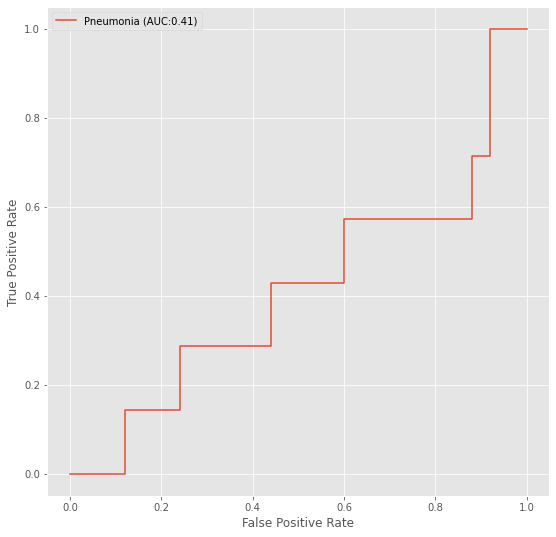

In [89]:
plot_auc(valY, pred_Y2)

### Architecture 3 ROC

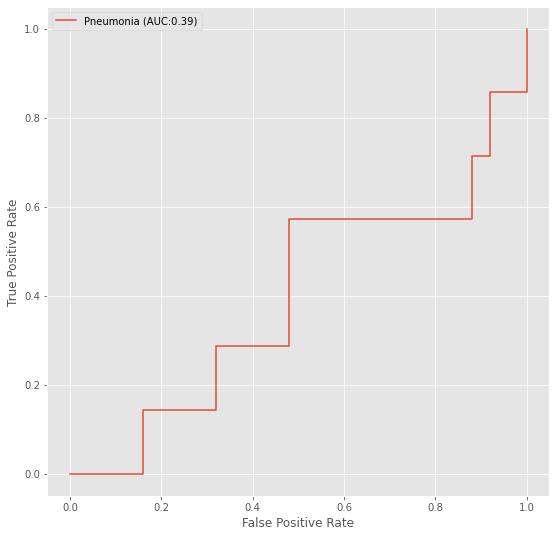

In [97]:
plot_auc(valY, pred_Y3)

# PR CURVE ,F1 SCORE AND THRESHOLDING

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [75]:
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)

### Architecture 1 Analysis

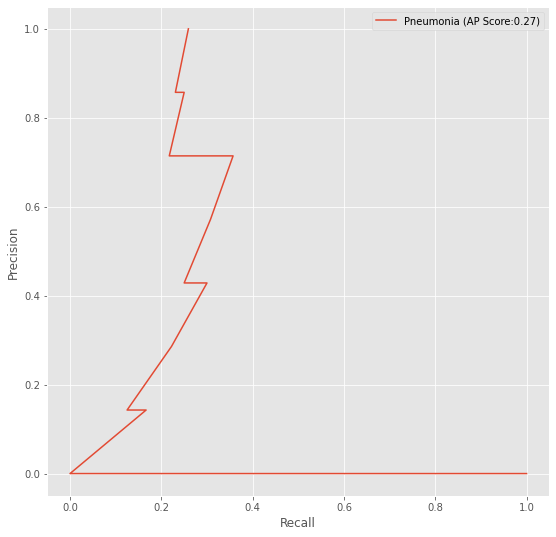

In [76]:
plot_pr(valY, pred_Y)

In [117]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

In [118]:
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 0.0


IndexError: index 26 is out of bounds for axis 0 with size 26

In [119]:
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.24
Recall is: 0.8571428571428571
Threshold is: 0.45787317
F1 Score is: 0.375


### Architecture 2 Analysis

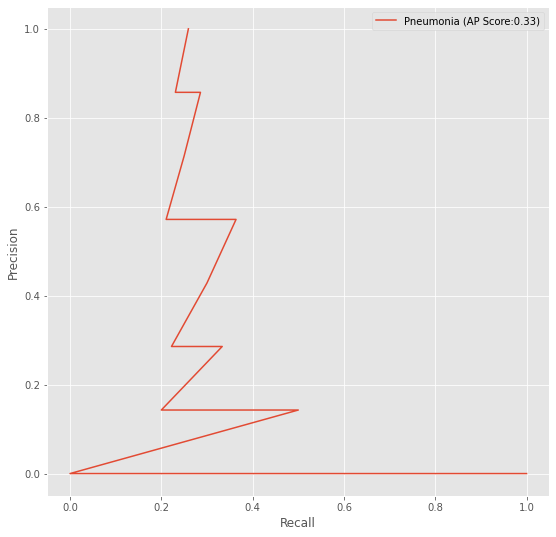

In [109]:
plot_pr(valY, pred_Y2)

In [110]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y2)

In [111]:

# Look at the threshold where precision is 0.8
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 0.0


IndexError: index 27 is out of bounds for axis 0 with size 27

In [112]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.23076923076923078
Recall is: 0.8571428571428571
Threshold is: 0.4646625
F1 Score is: 0.36363636363636365


### Architecture 3 Analysis

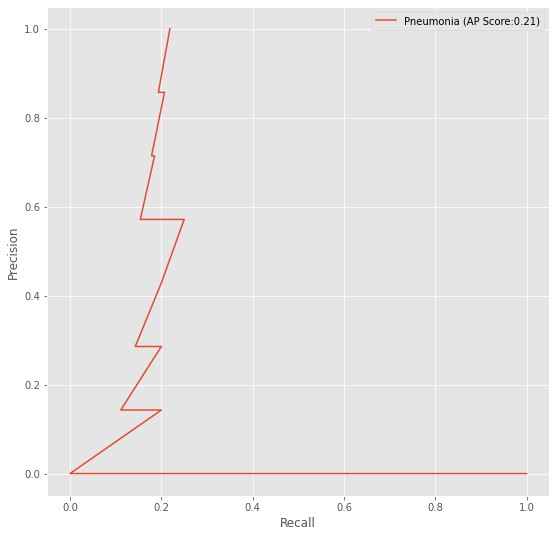

In [98]:
plot_pr(valY, pred_Y3)

In [123]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y3)

In [127]:
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.26666666666666666
Recall is: 0.5714285714285714
Threshold is: 0.4936746
F1 Score is: 0.36363636363636365


In [125]:
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.1935483870967742
Recall is: 0.8571428571428571
Threshold is: 0.48944268
F1 Score is: 0.3157894736842105


In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)